In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.linear_model import LinearRegression
import math

# River chemistry data for the pan-Arctic

Aim: have monthly mean chemistry for big suite of chemical variables required by marine modellers, for all RADR catchments + Greenland, for the period 1980-2019

Approach:

1. Big 6 rivers: base on observed data from ArcticGRO

    * Quick plot of time series to see how long the record is, gaps, etc. in each river
    * Derive a regressions with Q:
        * For the three sites where chemistry is measured a long way away from discharge, adjust the datetime by offsetting, so that the new timestamp matches the day when discharge is measured
        * For each chem variable, and for a variety of temporal aggregations (e.g. daily, monthly):
            * Plot QC
            * Plot logQ-logC
            * Fit linear regression. How good is regression?
        * Use regressions with Q to derive daily or monthly concentration in each river for full baseline period.
     * For DON, predict using DOC rather than Q
     * For some species, there was no relationship with Q, so constant concentrations are assumed (P species).

**To do still:**

- I jumped straight into QC regressions, as these are needed for the first half of the study period. However, for the period with chem data, perhaps I can just convert observed data to monthly frequency and interpolate? Interpolating daily data didn't work well, but perhaps averaging monthly and then interpolating would work better? Try this.
- cleaned Q data has been truncated to the end of 2019 (modelling period). But for deriving regressions would be good to include all the available chem data, i.e. to the end of 2020. So make 2 versions of the Q data, or just have the cleaned Q data to the end of 2020 instead.
- Work on DOC regressions more. Log-log QC is ok for all but Lena, Yukon and especially the Mackenzie. For these, there appears to be a constant concentration in baseflow and then an increase as Q increases. Could e.g. split by season (winter vs rest of year).
- R2 for fitted models apply to log-log transformed data. Need to also look at R2, bias, etc. of predictions (with bias-adjusted backtransform).
- Look more at Hg. Here there is data for UTHg. There is supposed to be UMeHg data (plot of the data is available online), but sheet is empty. Need to email them.
- Monthly mean concentrations: The Yukon has a big gap in the middle when no flow data was available. Is the Yukon actually in the model domain? If it is, I'll patch the gap using monthly means from the rest of the period. Have started doing this (bottom of notebook), but will check if it's needed in BEST-Siberian before proceeding.

Then in future notebooks need to:

2. Predict water quality in the rest of the unmonitored AO
    How to do this?
    * Lit review. Catchment characteristics.
    * Focus in particular on DOC, DIC, Hg. Rest can be based on same methods used in A20 hindcast Andre and Phil did.

## User input

In [2]:
# Location of cleaned discharge data
q_cleaned_daily_folder = r'~/shared/pan_arctic_data/discharge/ArcticGRO/data/cleaned_daily'
q_cleaned_monthly_folder = r'~/shared/pan_arctic_data/discharge/ArcticGRO/data/cleaned_monthly'

in_chem_file = r'~/shared/pan_arctic_data/water_quality/ArcticGRO/ArcticGRO Water Quality Data_2022-02.xlsx'
out_folder_qc = r'../output/predicted_arcticgro_chem/diagnostics/qc_regressions'
out_folder_predictions = r'../output/predicted_arcticgro_chem'

## Read in chem data

In [3]:
xl = pd.ExcelFile(in_chem_file)
rivers_li = xl.sheet_names[:-1]
rivers_li

['Ob', 'Yenisey', 'Lena', 'Kolyma', 'Yukon', 'Mackenzie']

In [4]:
chem_dict = {}  # key: river name (from rivers_li)

for river in rivers_li:
    df = pd.read_excel(in_chem_file, sheet_name=river, header=8, index_col=2,
                       skiprows=[9], parse_dates=True)

    # Calculate DON (mg/l) and add to dataframe
    df['DON'] = df['TDN'] - (df['NO3'] + df['NH4'])/1000
    df.loc[df['DON'] < 0, 'DON'] = 0  # set any negative values to 0

    # Calculate DHP (dissolved hydrolysable P)
    df['DHP'] = df['TDP'] - df['PO4']
    df.loc[df['DHP'] < 0, 'DHP'] = 0  # set any negative values to 0

    # Add DOC:x mass ratios and fix divide by zero issues
    df['DOC_DON'] = df['DOC']/df['DON']
    df.loc[~np.isfinite(df['DOC_DON']), 'DOC_DON'] = np.nan

    # Add x:DOC ratios (keep original units, so not genuine mass ratios for some)
    for var in ['TDP', 'DHP', 'UTHg']:
        df['%s_DOC' % var] = df[var]/df['DOC']
        df.loc[~np.isfinite(df['%s_DOC' % var]), '%s_DOC' % var] = np.nan

    chem_dict[river] = df

chem_dict['Ob'].head()

,Phase,River,ID,Discharge,Temp,pH,Cond,Alk,A254,A375,...,POC (2),POC-13C (2),PON (2),PON-15N (2),DON,DHP,DOC_DON,TDP_DOC,DHP_DOC,UTHg_DOC
Date,,,,,,,,,,,,,,,,,,,,,
2003-07-16,PARTNERS,Ob',NaN,31200.0,19.8,7.5,NaN,44.9,NaN,NaN,...,NaN,NaN,NaN,NaN,0.35812,NaN,30.660114,5.446266,NaN,NaN
2004-04-05,PARTNERS,Ob',NaN,3553.0,-1.0,7.0,NaN,130.6,NaN,NaN,...,NaN,NaN,NaN,NaN,0.10139,NaN,54.245981,2.770909,NaN,NaN
2004-06-15,PARTNERS,Ob',NaN,34500.0,10.5,7.7,NaN,32.9,NaN,NaN,...,NaN,NaN,NaN,NaN,0.23439,NaN,37.160288,3.394948,NaN,NaN
2004-06-17,PARTNERS,Ob',NaN,34500.0,12.6,7.7,NaN,34.4,NaN,NaN,...,NaN,NaN,NaN,NaN,0.20965,NaN,41.545433,3.394948,NaN,NaN
2004-07-28,PARTNERS,Ob',NaN,26000.0,20.0,7.5,NaN,38.4,NaN,NaN,...,NaN,NaN,NaN,NaN,0.42492,NaN,28.264144,4.357202,NaN,NaN


In [5]:
chem_dict['Ob'].columns

Index(['Phase', 'River', 'ID', 'Discharge', 'Temp', 'pH', 'Cond', 'Alk',
       'A254', 'A375', 'A412', 'A420', 'A440', 'H2O-2H', 'H2O-18O', 'DOC',
       'DOC-13C', 'DOC-14C', 'DOC-fm', 'TDN', 'NO3', 'NH4', 'TDP', 'PO4',
       'SiO2', 'Na', 'K', 'Mg', 'Ca', 'As', 'Ba', 'Cl', 'SO4', 'Li', 'Rb',
       'Sr', 'U', 'F', 'UTHg', 'UMeHg', 'TSS', 'POC', 'POC-13C', 'POC-14C',
       'POC-fm', 'PON', 'PON-15N', 'Sample depth 1', 'TSS (1)', 'POC (1)',
       'POC-13C (1)', 'PON (1)', 'PON-15N (1)', 'Sample depth 2', 'TSS (2)',
       'POC (2)', 'POC-13C (2)', 'PON (2)', 'PON-15N (2)', 'DON', 'DHP',
       'DOC_DON', 'TDP_DOC', 'DHP_DOC', 'UTHg_DOC'],
      dtype='object')

# Read in discharge data

In [6]:
q_dict = {}

for river in rivers_li:
    fpath = os.path.join(q_cleaned_daily_folder, "%s_daily_1980-2019.csv" % river)
    q_df = pd.read_csv(fpath, index_col=0, parse_dates=True)
    q_dict[river] = q_df

q_dict['Ob'].head()

,discharge
date,
1980-01-01,7360.0
1980-01-02,7350.0
1980-01-03,7350.0
1980-01-04,7320.0
1980-01-05,7290.0


# Make dataset including chem and Q

To do this, first need to apply date offset to get chem data as seen at discharge stations. 3 rivers monitor discharge and chemistry in different places, so following method used by Holmes et al. (): Calculate lag time between the two sampling stations by assuming river velocities of 1.5 m/s. Therefore use measured concentrations and assume they were observed at downstream locations on day + lag. Work out lags to apply as follows:
* Lena: water chem is 520 m U/S of discharge. Lag of ~4 days. Add 4 days to the WQ dates.
* Yenisey: WQ is 250 km D/S of Q. Lag of ~-2 days. Subtract 2 days.
* Kolyma: WQ is 150 km D/S of Q. Lag of ~-1 day. Subtract 1 day.

Also add discharge data for sampling dates. The ArcticGRO water quality data includes discharge data already. This is usually the same as the ArcticGRO discharge data for the same date, but not always. Perhaps it is because of the data cleaning I did, or patching, or perhaps they made errors too. Either way, I will use my cleaned data as the basis, rather than the discharge data included with the chem data.

Also truncate to just the chem variables of interest.

In [7]:
# N.B. 'UMeHg' is also of interest, but for some reason there is no
# data for any site. Need to follow up.
# Have replaced TDN with DON, as TDN didn't show a relationship with Q
chem_vars = ['Alk', 'DOC',
             'DON', 'DOC_DON',
             'NO3', 'NH4',
             'TDP', 'PO4',
             'SiO2', 'UTHg', 'POC', 'PON',
             'DHP',
             'TDP_DOC', 'DHP_DOC', 'UTHg_DOC']

lag_dict = {'Lena': 4,
            'Yenisey': -2,
            'Kolyma': -1}

chem_q_daily_dict = {}
chem_q_monthly_dict = {}

for river in rivers_li:
    chem_df = chem_dict[river].copy()

    # Drop unwanted cols
    chem_df = chem_df.loc[:, chem_vars]

    # Convert to daily frequency, in prep for time shift for some rivs, and converting
    # to monthly freq for all
    chem_df_daily = chem_df.asfreq('D')
    chem_df_daily = chem_df_daily.loc[:'2019-12-31']  # Truncate to period of interest

    # For some rivs, apply time shift so chem dates are on the day at which that water parcel
    # would be seen at the gauging station ('ish)
    if river in lag_dict.keys():
        chem_df_daily = chem_df_daily.shift(lag_dict[river])

    # Add discharge data to the chem data (from cleaned ArcticGRO discharge files,
    # rather than using the 'Discharge' column in the WQ data)
    chem_df_daily['Q'] = q_dict[river].loc[chem_df_daily.index]

    # Also calculate monthly mean discharge and chem
    chem_df_monthly = chem_df_daily.resample('M').agg(np.mean)

    # Drop rows where all are NaNs (i.e. drop the daily or monthly freq)
    # chem_df_daily.dropna(subset=chem_df_daily.columns.difference(['Q']),
    #                      how="all", inplace=True)
    # chem_df_monthly.dropna(subset=chem_df_monthly.columns.difference(['Q']),
    #                        how="all", inplace=True)

    # Add to dicts
    chem_q_daily_dict[river] = chem_df_daily
    chem_q_monthly_dict[river] = chem_df_monthly

# Check at Lena. DOC was 5.2 on 2003-08-12. Should now be 5.2 on 2003-08-16. Ok.
print("Check of offset at Lena:")
print(chem_q_daily_dict['Lena']['DOC'].head())

# Check new Q column is ok. Find: identical for US rivs, bit diff for Sib ones.
# So code is working ok.
# print(chem_q_daily_dict['Mackenzie'].loc[:, ['Discharge', 'Q']])
print("\n" "Check of daily data for Ob:")
print(chem_q_daily_dict['Ob'].head())

print("\n" "Check of monthly data for Ob:")
print(chem_q_monthly_dict['Ob'].head())

Check of offset at Lena:
Date
2003-08-12    NaN
2003-08-13    NaN
2003-08-14    NaN
2003-08-15    NaN
2003-08-16    5.2
Freq: D, Name: DOC, dtype: float64

Check of daily data for Ob:
             Alk    DOC      DON    DOC_DON    NO3    NH4   TDP  PO4  SiO2  \
Date                                                                         
2003-07-16  44.9  10.98  0.35812  30.660114  49.02  42.86  59.8  NaN  3.86   
2003-07-17   NaN    NaN      NaN        NaN    NaN    NaN   NaN  NaN   NaN   
2003-07-18   NaN    NaN      NaN        NaN    NaN    NaN   NaN  NaN   NaN   
2003-07-19   NaN    NaN      NaN        NaN    NaN    NaN   NaN  NaN   NaN   
2003-07-20   NaN    NaN      NaN        NaN    NaN    NaN   NaN  NaN   NaN   

            UTHg   POC     PON  DHP   TDP_DOC  DHP_DOC  UTHg_DOC        Q  
Date                                                                       
2003-07-16   NaN  1.23  140.07  NaN  5.446266      NaN       NaN  31200.0  
2003-07-17   NaN   NaN     NaN  NaN      

# Explore QC relationships

## Time series

In [8]:
# Function to plot time series of chem and Q together for each river
def plot_timeseries(chem_var, rivers_li, chem_dict, q_dict):

    fig = plt.figure()

    for river in rivers_li:

        fig = plt.figure(figsize=(10, 5))

        # Plot chem data
        ax = fig.add_subplot()
        chem_df = chem_dict[river][chem_var]
        chem_df.plot(marker='o', color='k', linestyle='none', grid=True, ax=ax)
        ax.set_ylabel(chem_var)
        ax.set_xlabel("")
        ax.legend('Chem', loc='upper left')

        # Plot Q data
        ax2 = ax.twinx()
        q_df = q_dict[river].loc['2003-01-01':]
        q_df.plot(ax=ax2)
        ax2.set_ylabel('Q')
        ax2.legend('Q', loc='upper right')

        # Tidy
        plt.title("%s" % str(river))
        plt.tight_layout()
        plt.show()

        plt.savefig(os.path.join(out_folder_qc, 'timeseries', 'q-chem',
                                 'timeseries_q_chem_%s_%s' % (chem_var, river)))

<Figure size 432x288 with 0 Axes>

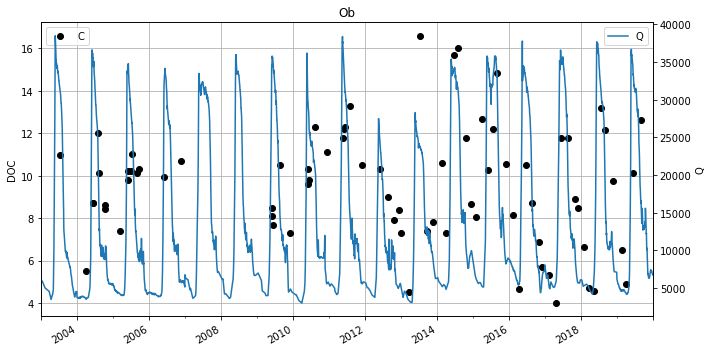

<Figure size 432x288 with 0 Axes>

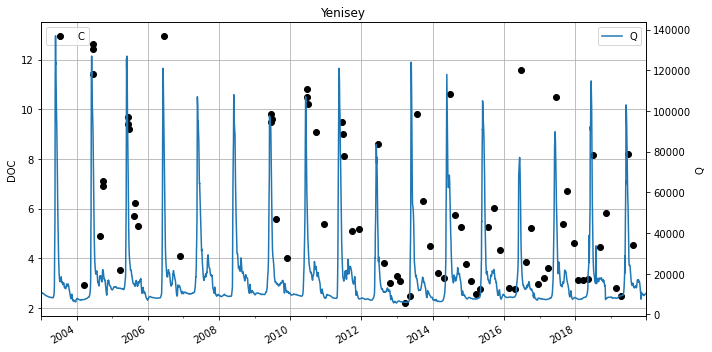

<Figure size 432x288 with 0 Axes>

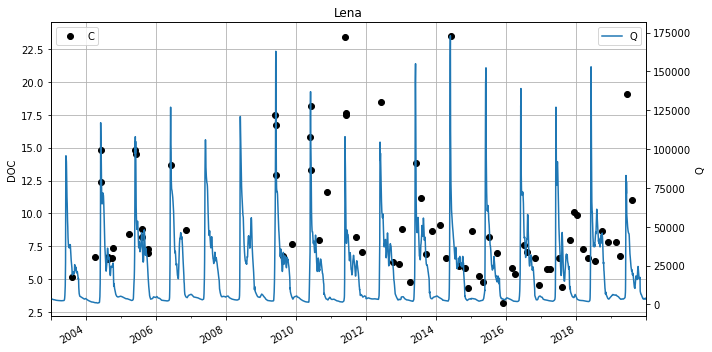

<Figure size 432x288 with 0 Axes>

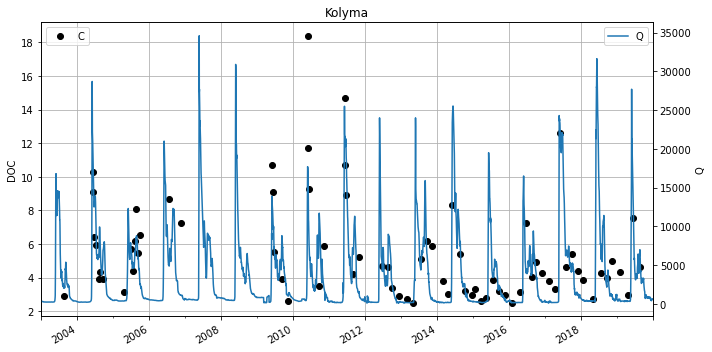

<Figure size 432x288 with 0 Axes>

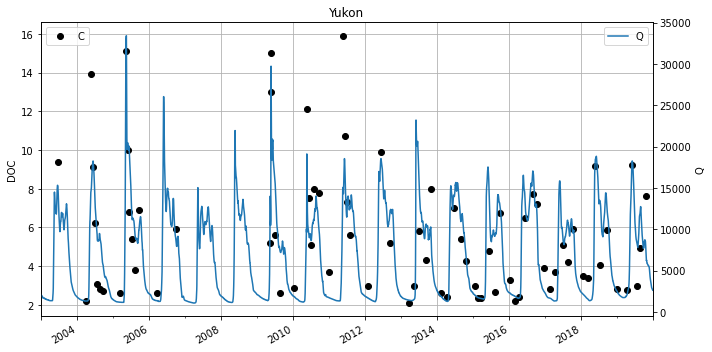

<Figure size 432x288 with 0 Axes>

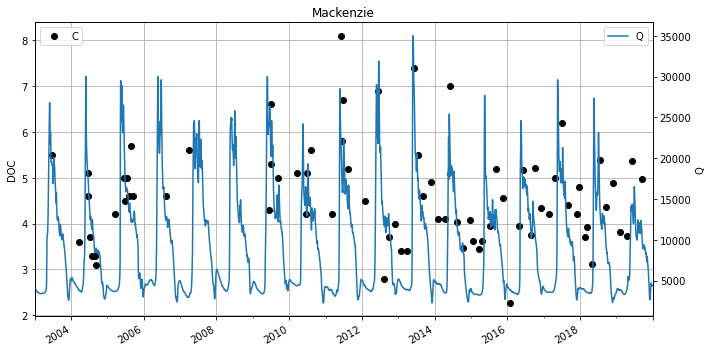

<Figure size 432x288 with 0 Axes>

In [9]:
plot_timeseries('DOC', rivers_li, chem_dict, q_dict)

## Chem vs Q

In [10]:
def q_c_linear_regression(chem_q_dict, chem_var, out_folder_qc,
                          log_q=False, log_chem=False,
                          monthly=False):
    """ """

    fig, axs = plt.subplots(nrows=1, ncols=len(rivers_li),
                            sharex=False, sharey=False, figsize=(17, 3))
    axs = axs.flatten()

    reg_dict = {}  # Key: river, returns sklearn linear regression model
    r2_s = pd.Series(dtype=np.float64)
    alpha_s = pd.Series(dtype=np.float64)

    for i, river in enumerate(rivers_li):
        df = chem_q_dict[river].loc[:, ["Q", chem_var]]
        # print(df.isnull().sum())  # 1 NA in DOC in Ob, Lena and Kolyma
        df = df.dropna()
        if len(df) < 20:
            continue  # i.e. don't do for this river, not enough data

        # If desired, log transform the data first
        if log_q is True:
            df["Q"] = np.log10(df["Q"])
            xlabel = "Log10 Q"
        else:
            xlabel = "Q"

        if log_chem is True:
            # To avoid log(0) errors, replace zeros with a small value
            # (1/200 of the mean). Or NaN
            # sub_value = df[chem_var].mean()/200
            sub_value = np.NaN
            df.loc[df[chem_var] == 0, chem_var] = sub_value
            df = df.dropna()
            # Then work out log
            df[chem_var] = np.log10(df[chem_var])
            # And set how the y-axis label will look
            ylabel = "Log10 %s" % chem_var
        else:
            ylabel = chem_var

        # Fit regression
        x = df["Q"].values.reshape((-1, 1))
        y = df[chem_var].values

        model = LinearRegression().fit(x, y)
        reg_dict[river] = model
        y_pred = model.predict(x)
        residuals = (y - y_pred)

        # To bias correct when back-transforming, calculate alpha
        alpha = np.exp(2.651*((residuals)**2).mean())
        alpha_s.loc[river] = alpha
        alpha_s.name = chem_var

        # Save regression results to a dataframe
        r_sq = model.score(x, y)
        r2_s.loc[river] = r_sq
        r2_s.name = chem_var
#         fit_c = model.intercept_
#         fit_m = model.coef_

#         # This results in a warning, but results are as desired, so supress warning
#         np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
#         linear_reg_df.loc[river, ["R2", "m", "c"]] = [r_sq, fit_c, fit_m]

        # Plot output of linear regression
        axs[i].scatter(x, y, color="black")
        axs[i].plot(x, y_pred, color="blue", linewidth=2)
        axs[i].set_xlabel(xlabel)
        if i == 0:
            axs[i].set_ylabel(ylabel)
        axs[i].set_title(river)

    plt.tight_layout()

    # Sort out file names and save
    if monthly is True:
        freq_str = "monthly"
    else:
        freq_str = "daily"

    # linear_reg_df.to_csv(
    #     os.path.join(
    #         out_folder_qc,
    #         "qc_regression_%s_%s_logq-%s_logchem_%s.csv"
    #         % (chem_var, freq_str, log_q, log_chem),
    #     ),
    #     index_label="River",
    # )
    plt.savefig(
        os.path.join(
            out_folder_qc,
            'scatterplots',
            "qc_scatter_%s_%s_logq-%s_logchem_%s.png"
            % (chem_var, freq_str, log_q, log_chem),
        )
    )

    # print(linear_reg_df)
    return (reg_dict, r2_s, alpha_s)

({'Ob': LinearRegression(),
  'Yenisey': LinearRegression(),
  'Lena': LinearRegression(),
  'Kolyma': LinearRegression(),
  'Yukon': LinearRegression(),
  'Mackenzie': LinearRegression()},
 Ob           0.295192
 Yenisey      0.754356
 Lena         0.528598
 Kolyma       0.645068
 Yukon        0.635344
 Mackenzie    0.395186
 Name: DOC, dtype: float64,
 Ob           1.044607e+06
 Yenisey      3.713379e+02
 Lena         1.585761e+11
 Kolyma       5.815500e+03
 Yukon        5.461374e+04
 Mackenzie    6.195127e+00
 Name: DOC, dtype: float64)

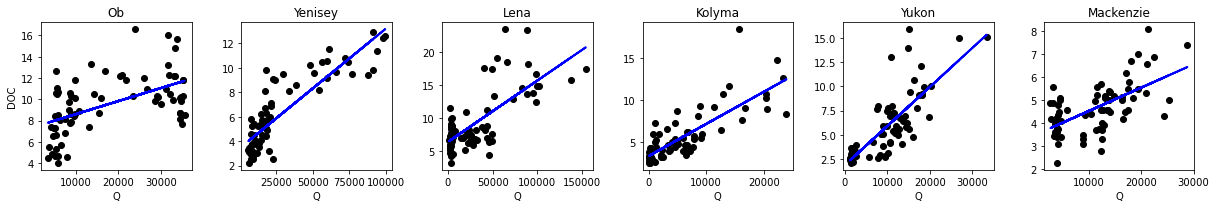

In [11]:
q_c_linear_regression(chem_q_daily_dict, 'DOC', out_folder_qc)

### Loop through all chem vars and rivs and derive QC regression

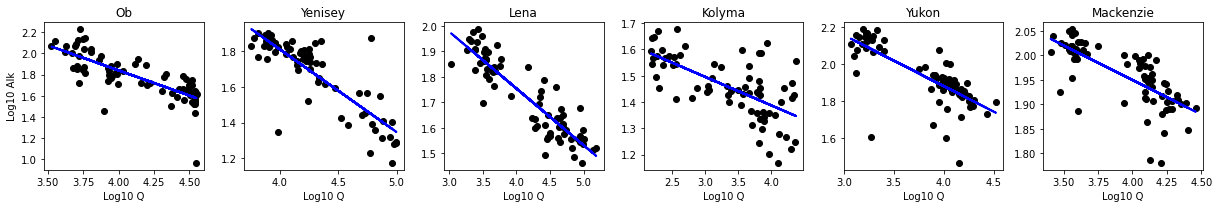

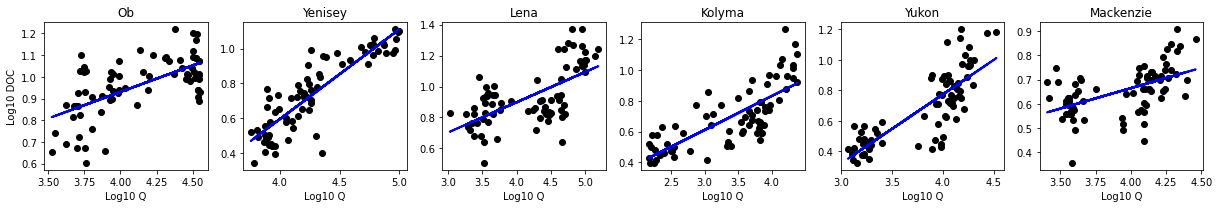

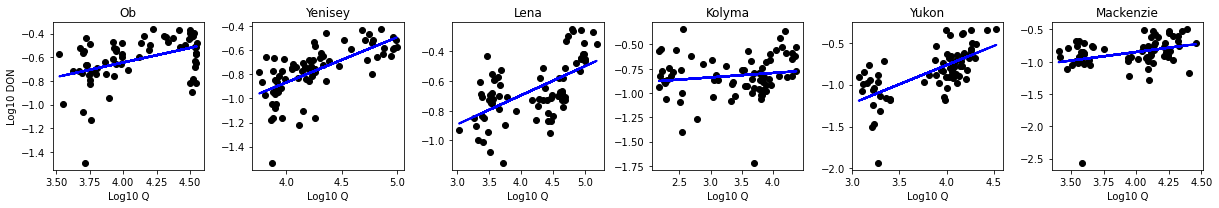

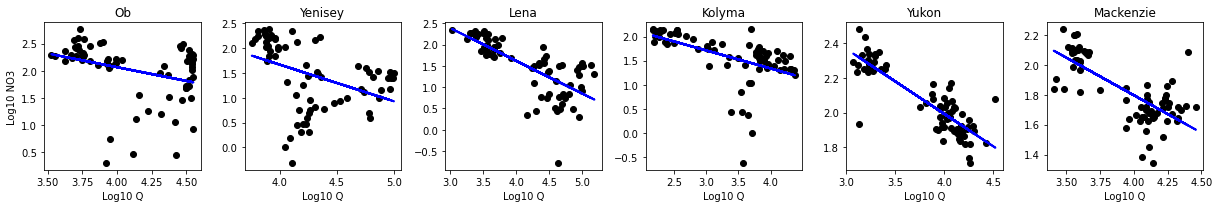

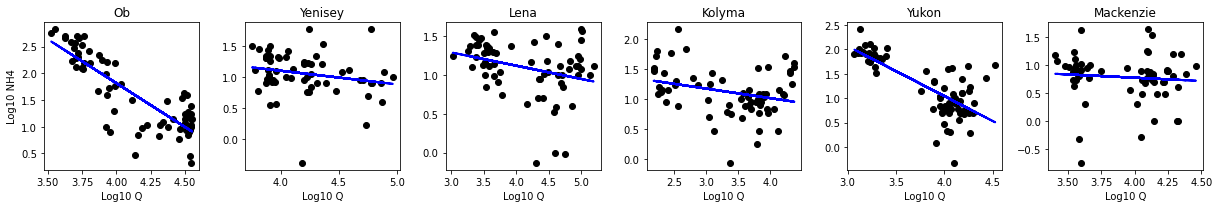

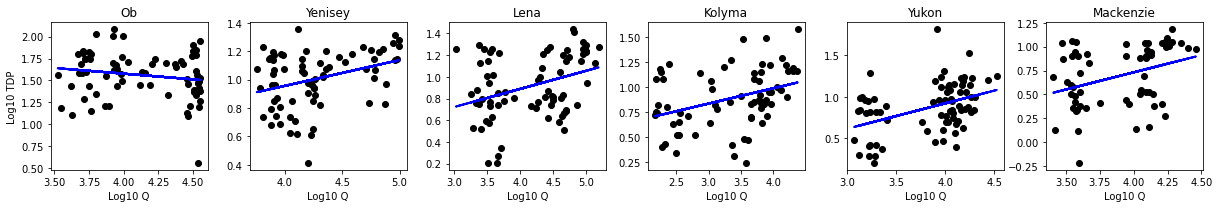

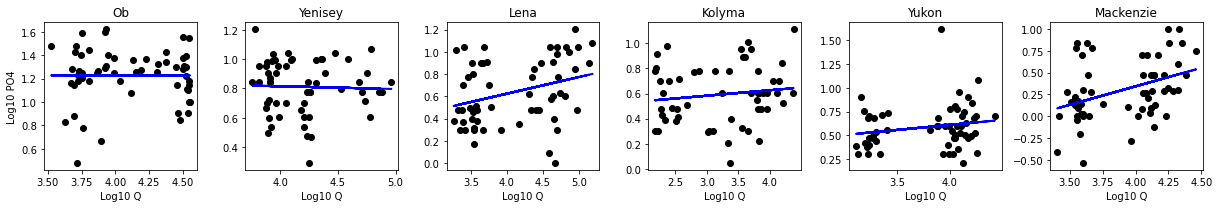

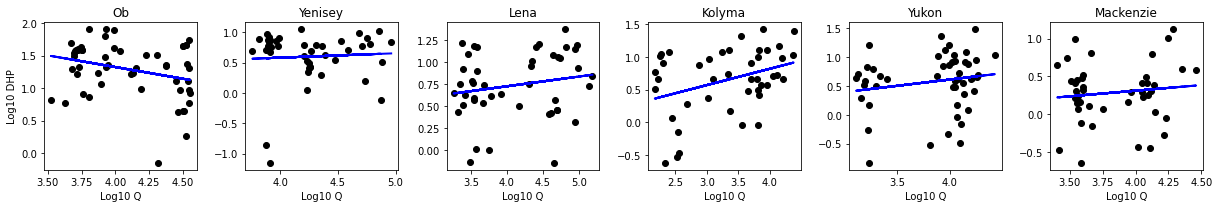

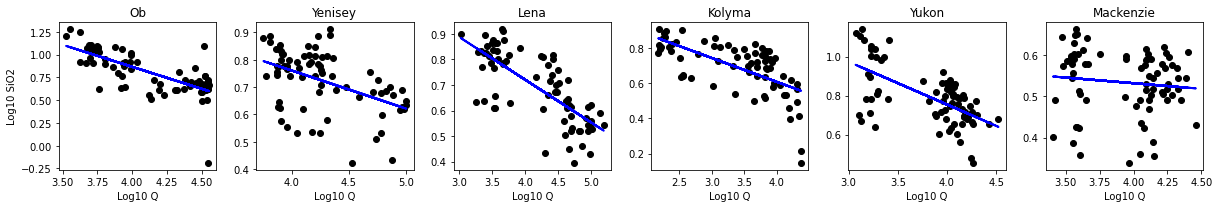

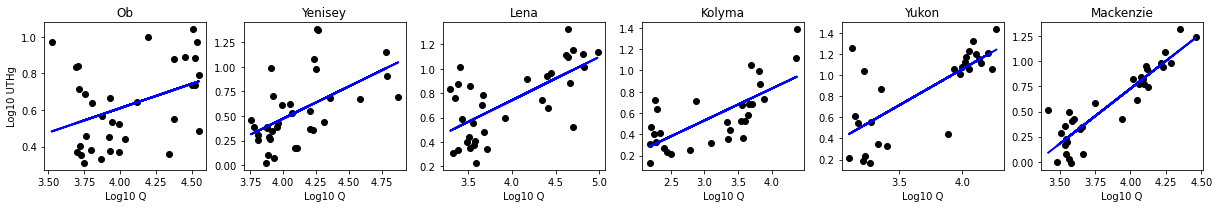

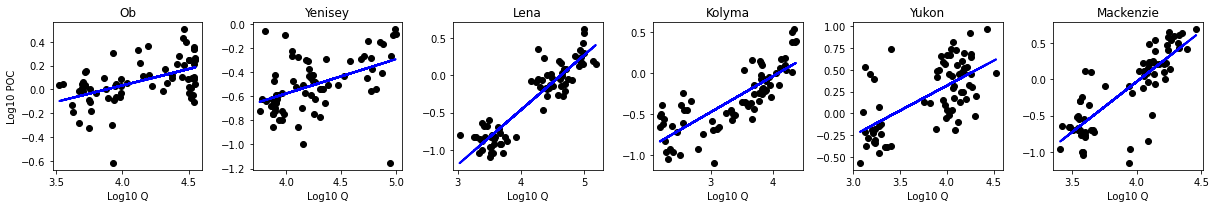

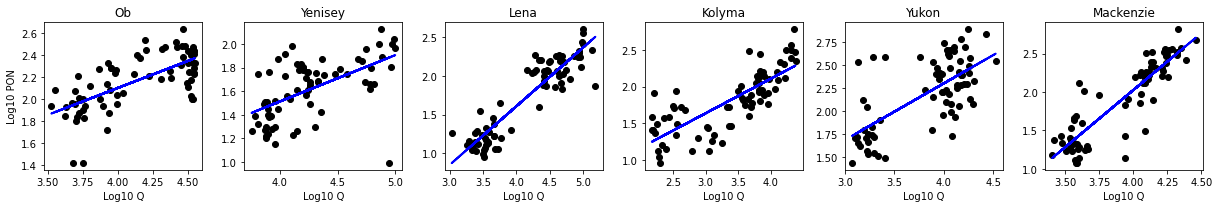

In [12]:
chem_vars_cq = [
    "Alk",
    "DOC",
    "DON",
    "NO3",
    "NH4",
    "TDP",
    "PO4",
    "DHP",
    "SiO2",
    "UTHg",
    "POC",
    "PON",
]

# Key: chem_var, returns dict with key river, returns regression model.
reg_dict_untransf = {}
reg_dict_log = {}
r2_li = []
alpha_li = []

for chem_var in chem_vars_cq:
    reg_dict_log[chem_var], r2s, alphas = q_c_linear_regression(
        chem_q_daily_dict, chem_var, out_folder_qc, log_chem=True, log_q=True
    )

    r2_li.append(r2s)
    alpha_li.append(alphas)

    # reg_dict_untransf[chem_var] = q_c_linear_regression(chem_q_daily_dict,
    #                                                     chem_var,
    #                                                     out_folder_qc,
    #                                                     log_chem=False,
    #                                                     log_q=False)
    # q_c_linear_regression(chem_q_monthly_dict, chem_var, out_folder_qc, monthly=True)

r2_df = pd.concat(r2_li, axis=1)
alpha_df = pd.concat(alpha_li, axis=1)

In [13]:
r2_df

,Alk,DOC,DON,NO3,NH4,TDP,PO4,DHP,SiO2,UTHg,POC,PON
Ob,0.610418,0.388704,0.181265,0.110573,0.712722,0.029346,0.000001,0.085910,0.524009,0.151284,0.255959,0.455297
Yenisey,0.720334,0.765380,0.430886,0.163388,0.047441,0.114752,0.001177,0.003303,0.215680,0.296045,0.206288,0.324481
Lena,0.816671,0.403097,0.349217,0.524695,0.090707,0.118611,0.096047,0.033836,0.546998,0.441375,0.839452,0.840109
Kolyma,0.418333,0.587119,0.020946,0.268445,0.083170,0.135864,0.017139,0.125836,0.411855,0.504940,0.646397,0.625637
Yukon,0.568962,0.646444,0.435838,0.734271,0.562577,0.177104,0.035163,0.031976,0.390270,0.537848,0.402848,0.455564
Mackenzie,0.520751,0.278163,0.098478,0.536922,0.007314,0.118228,0.150572,0.013120,0.011613,0.830754,0.673159,0.788250


In [14]:
alpha_df

,Alk,DOC,DON,NO3,NH4,TDP,PO4,DHP,SiO2,UTHg,POC,PON
Ob,1.046021,1.029904,1.088769,1.939229,1.420796,1.193131,1.148674,1.526654,1.068614,1.117521,1.071411,1.093538
Yenisey,1.030681,1.029597,1.068688,2.783292,1.341988,1.095437,1.090786,1.654266,1.025815,1.255280,1.113437,1.117456
Lena,1.010841,1.056864,1.071424,1.683897,1.353704,1.224039,1.226752,1.419452,1.022943,1.139000,1.102920,1.108981
Kolyma,1.021494,1.045059,1.134054,1.652539,1.441806,1.210412,1.154185,1.768146,1.034462,1.119101,1.144766,1.190717
Yukon,1.027118,1.053693,1.130351,1.023594,1.472011,1.222228,1.145804,1.864546,1.035361,1.217264,1.260388,1.242375
Mackenzie,1.004668,1.018760,1.177145,1.056344,1.601789,1.269996,1.304962,1.492823,1.016157,1.064042,1.262934,1.159116


# Relationships between chem vars

## Exploration

In [15]:
def chem_ratios(x_var, y_var):

    ratio_df = pd.DataFrame()
    fig, axs = plt.subplots(nrows=1, ncols=len(rivers_li),
                            sharex=False, sharey=False, figsize=(17, 3))
    axs = axs.flatten()

    for i, river in enumerate(rivers_li):
        df = chem_dict[river]

        mean_ratio = df['%s_%s' % (x_var, y_var)].dropna().mean()
        ratio_df.loc[river, 'Mean_%s_%s' % (x_var, y_var)] = mean_ratio

        # Plot scatter of x_var vs y_var
        axs[i].scatter(df[x_var], df[y_var], color="black")
        axs[i].set_xlabel(x_var)
        if i == 0:
            axs[i].set_ylabel(y_var)
        axs[i].set_title(river)

    mean_ratio = ratio_df.mean().values[0]

    plt.tight_layout()

    # Check for relationship between ratio and flow
    model_dict, r2s, alphas = q_c_linear_regression(chem_q_daily_dict, '%s_%s' % (x_var, y_var),
                                                    out_folder_qc,
                                                    log_chem=True,
                                                    log_q=True)

    print("Mean %s:%s ratio in ArcticGRO rivs: %s" % (x_var, y_var, mean_ratio))

    return(ratio_df)

Mean DOC:DON ratio in ArcticGRO rivs: 39.6318923841362


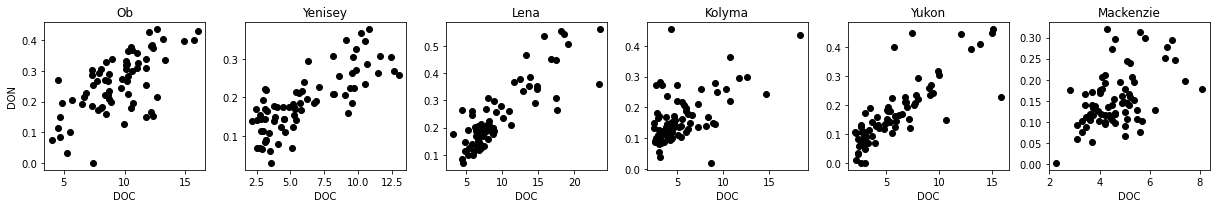

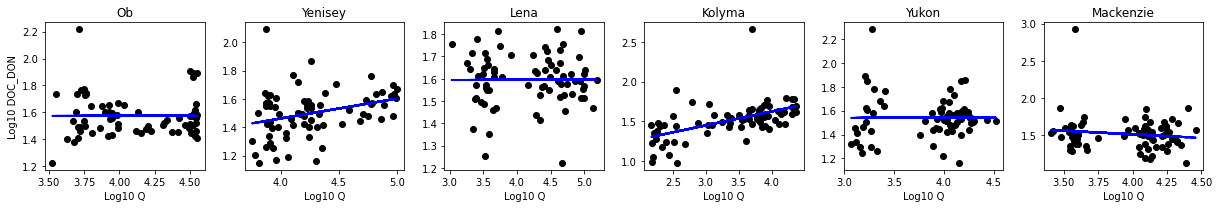

In [16]:
doc_don_df = chem_ratios('DOC', 'DON')

Mean DHP:DOC ratio in ArcticGRO rivs: 1.1971032995144437


,Mean_DHP_DOC
Ob,2.930588
Yenisey,0.792524
Lena,0.634709
Kolyma,1.187660
Yukon,1.027463
Mackenzie,0.609676


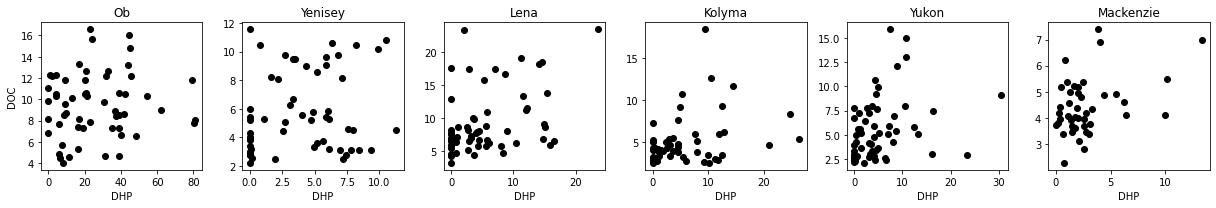

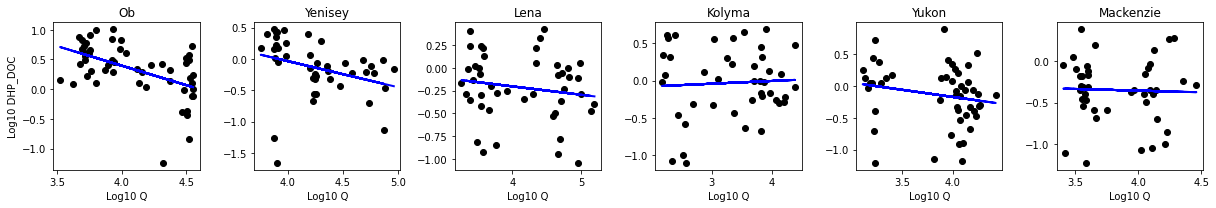

In [17]:
chem_ratios('DHP', 'DOC')

Mean TDP:DOC ratio in ArcticGRO rivs: 2.2256659148712585


,Mean_TDP_DOC
Ob,4.750799
Yenisey,2.181433
Lena,1.117711
Kolyma,1.941759
Yukon,1.947129
Mackenzie,1.415163


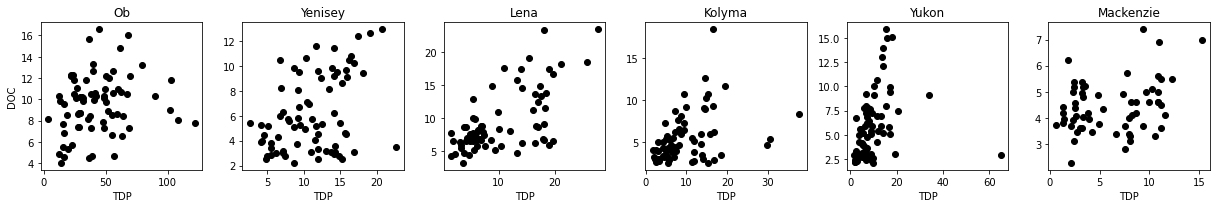

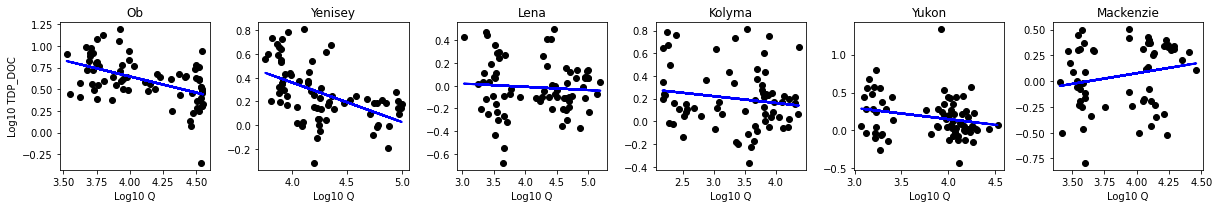

In [18]:
chem_ratios('TDP', 'DOC')

Mean UTHg:DOC ratio in ArcticGRO rivs: 1.1350831185712613


,Mean_UTHg_DOC
Ob,0.552253
Yenisey,1.027093
Lena,0.959230
Kolyma,1.011782
Yukon,2.155568
Mackenzie,1.104573


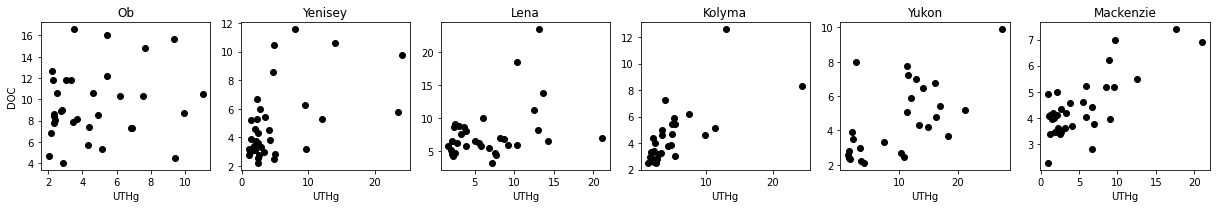

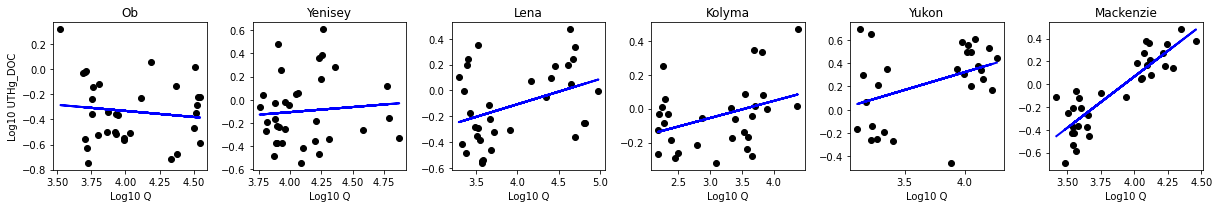

In [19]:
chem_ratios('UTHg', 'DOC')

**In summary:**

* Decide to use QC relationships for all but DON. Use DOC for this.

# Interpolation

Have a quick play with interpolating instead of using regressions to get daily chem data (like I did at Langtjern).

Decide not to pursue for now. Linear misses peaks, whilst polynomial fits some likely peaks better than linear, but does dangerous things.

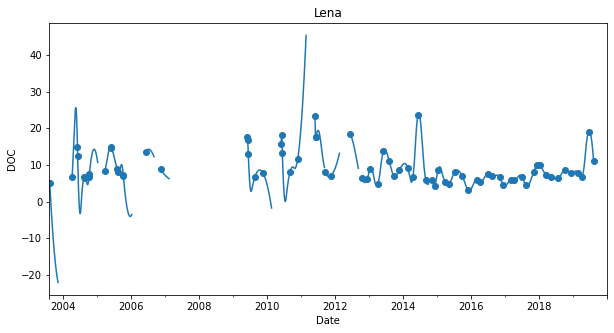

In [20]:
river = 'Lena'
chem = 'DOC'

df = chem_q_daily_dict[river][chem].to_frame()
df['%s_interp' % chem] = df['%s' % chem]
df['%s_interp' % chem] = df['%s' % chem].interpolate(method='polynomial',
                                                     order=2,
                                                     limit=90)

ax = df['%s_interp' % chem].plot(figsize=(10, 5))
plt.scatter(df.index, df['%s' % chem])
# predicted_chem_dict[chem][river].loc['2003-01-01':].plot(ax=ax, linestyle=None, grid=True)
plt.ylabel('%s' % chem)
plt.title(river);

# Predict chem for the period 1980-2019

In [21]:
def plot_predicted_obs_chem(df, chem, folder_for_graphs):
    """ Plot timeseries of predicted and observed
    """
    fig, axs = plt.subplots(len(rivers_li), 1, figsize=(12, 15))
    axs = axs.flatten()

    for i, river in enumerate(df.columns):
        pred = df[river]
        pred.loc['2003-01-01': '2019-12-31'].plot(ax=axs[i], label='Predicted')
        obs = chem_dict[river][chem]
        obs.loc['2003-01-01': '2019-12-31'].plot(marker='o',
                                                 color='k',
                                                 markersize=4,
                                                 linestyle='none',
                                                 grid=True,
                                                 ax=axs[i],
                                                 label='Observed')
        axs[i].set_ylabel(chem)
        axs[i].set_xlabel("")
        axs[i].set_title(river)
        if i == len(rivers_li)-1:
            axs[i].legend(loc='upper right')

    plt.tight_layout()
    fpath = os.path.join(folder_for_graphs, 'diagnostics', 'timeseries',
                         'predicted-vs-observed_%s.png' % chem)
    plt.savefig(fpath, dpi=300)

## All but DON and PO4: QC

In [22]:
chem_vars_cq = [
    "Alk",
    "DOC",
    "NO3",
    "NH4",
    "TDP",
    "PO4",
    "SiO2",
    "UTHg",
    "POC",
    "PON",
]

predicted_chem_dict = {}  # key: chem, returns df with one col per river

for chem in chem_vars_cq:
# for chem in ['Alk']:  # for testing

    pred_li = []

    for i, river in enumerate(rivers_li):

        # Get Q data
        q = q_dict[river]

        # Get regression result
        model = reg_dict_log[chem][river]
        alpha = alpha_df.loc[river, chem]
        # alpha = 1.0

        # Q data to make predictions with
        q = q_dict[river].squeeze()
        log10q = np.log10(q)

        # Predict and back-transform from log scale with bias correcn
        pred = 10 ** (model.intercept_ + model.coef_ * log10q)
        pred = alpha * pred

        # Add to results
        pred.name = river
        pred_li.append(pred)

    # Make dataframe for this variable and save in dict and to file
    pred_df = pd.concat(pred_li, axis=1)
    predicted_chem_dict[chem] = pred_df
    pred_fpath = os.path.join(out_folder_predictions, 'predictions',
                              'daily', '%s.csv' % chem)
    pred_df.to_csv(pred_fpath)

# Display example output
# predicted_chem_dict['Alk']

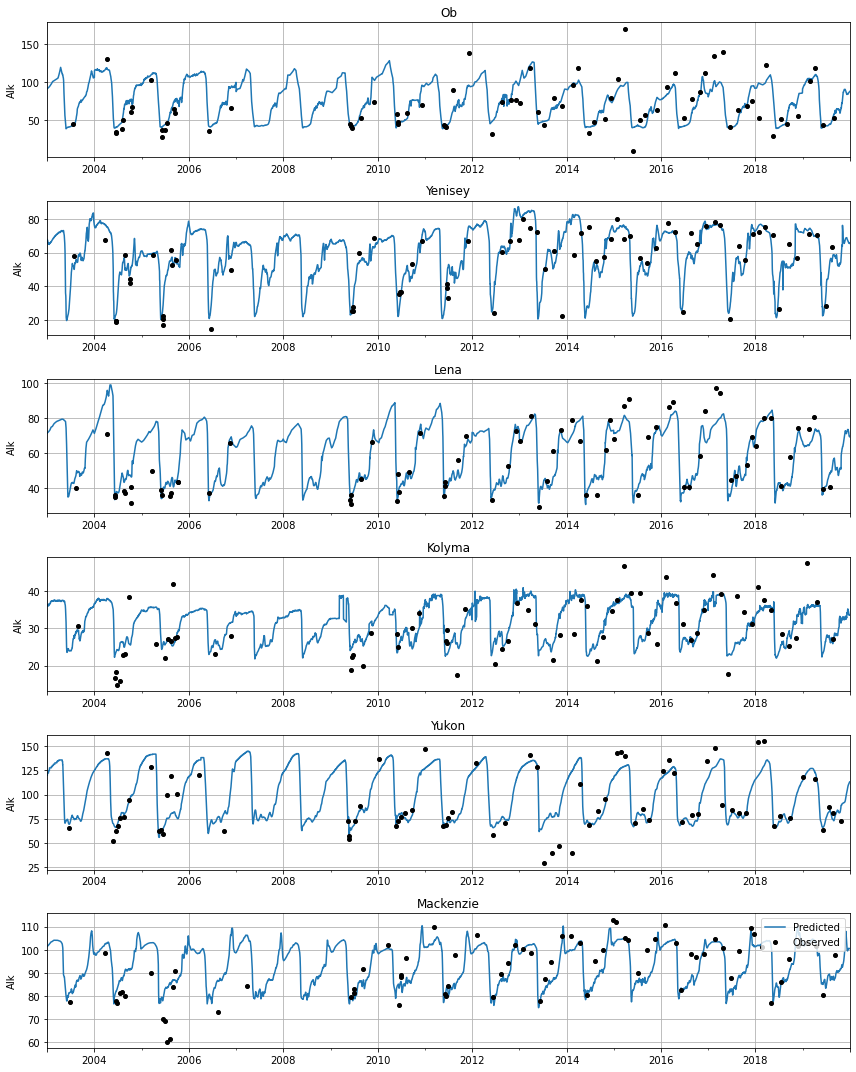

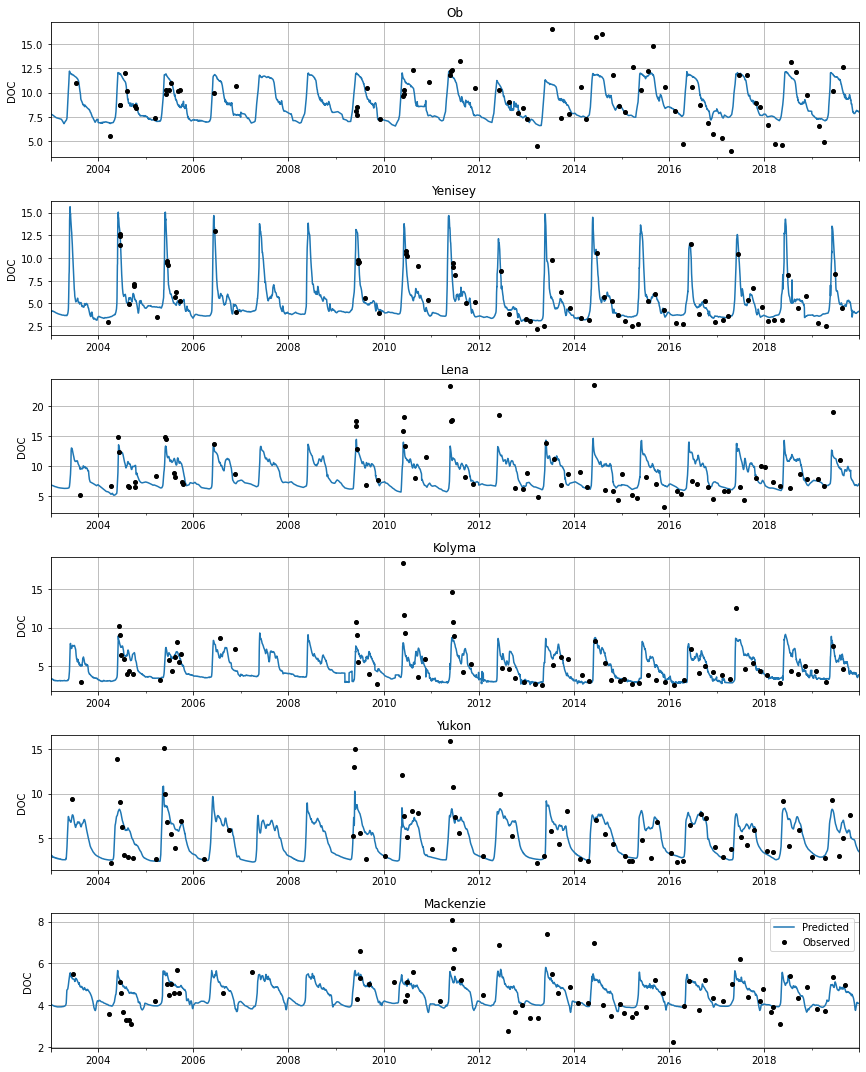

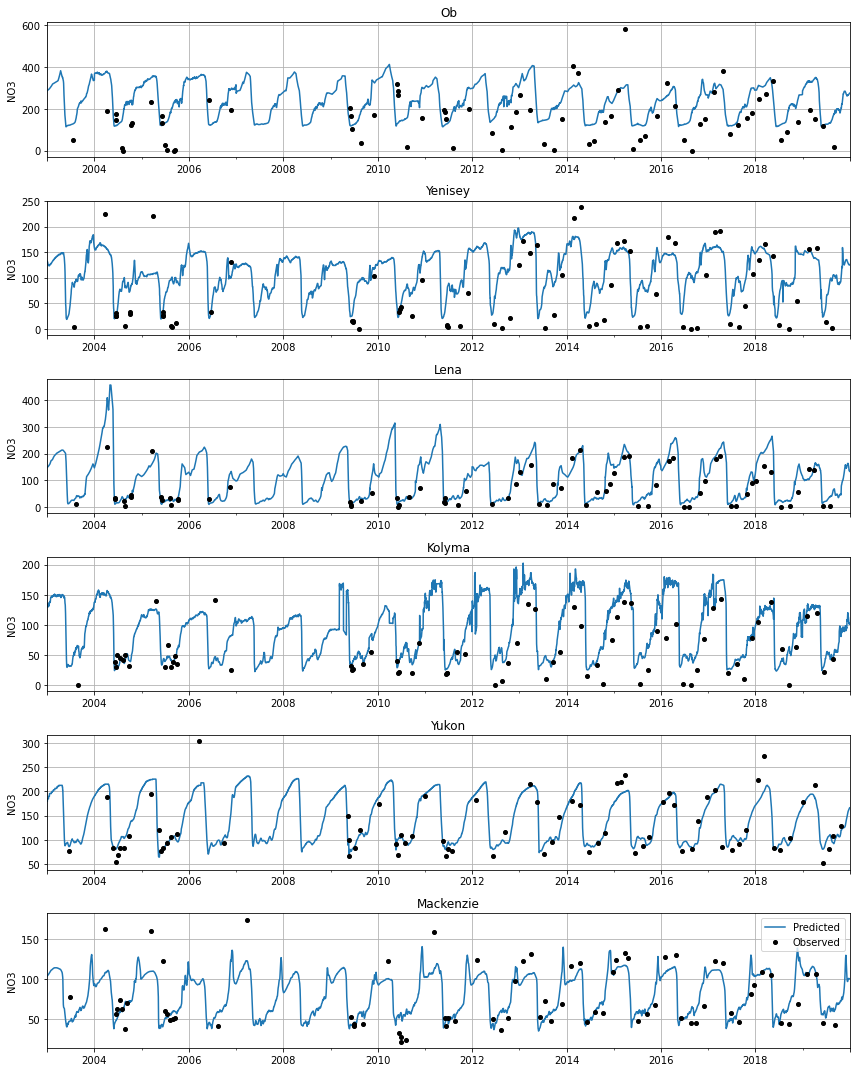

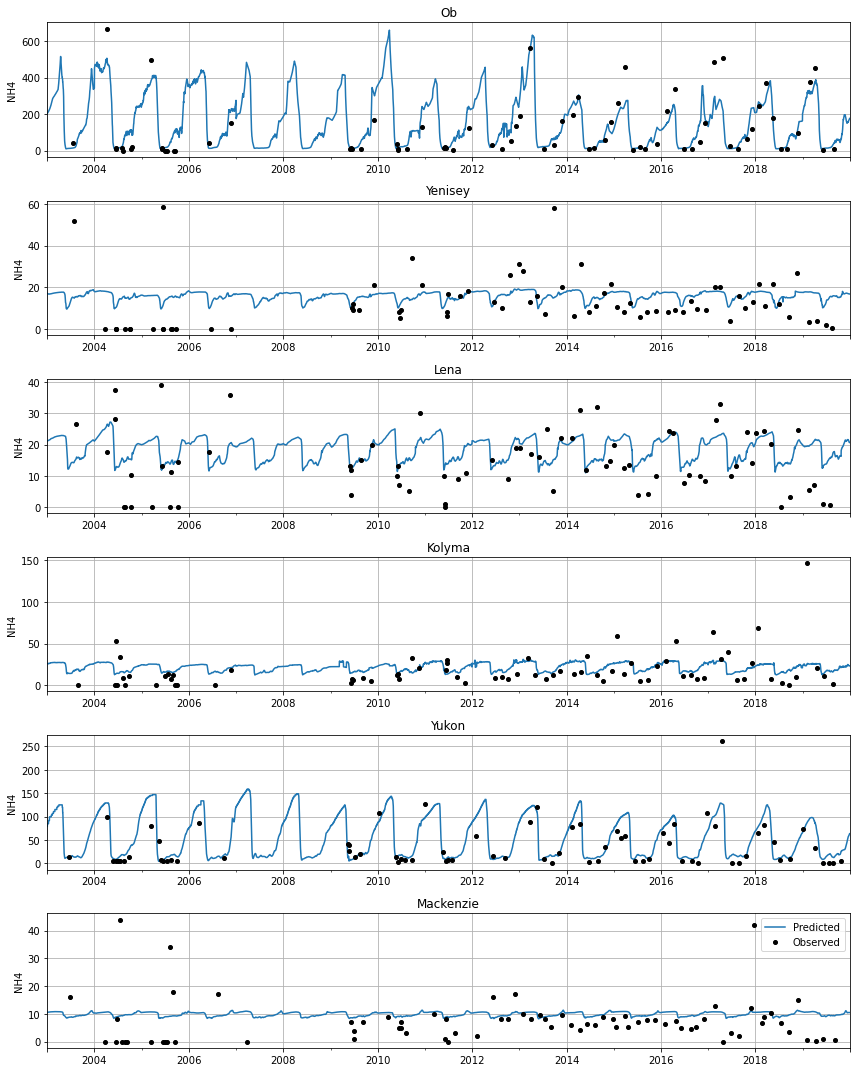

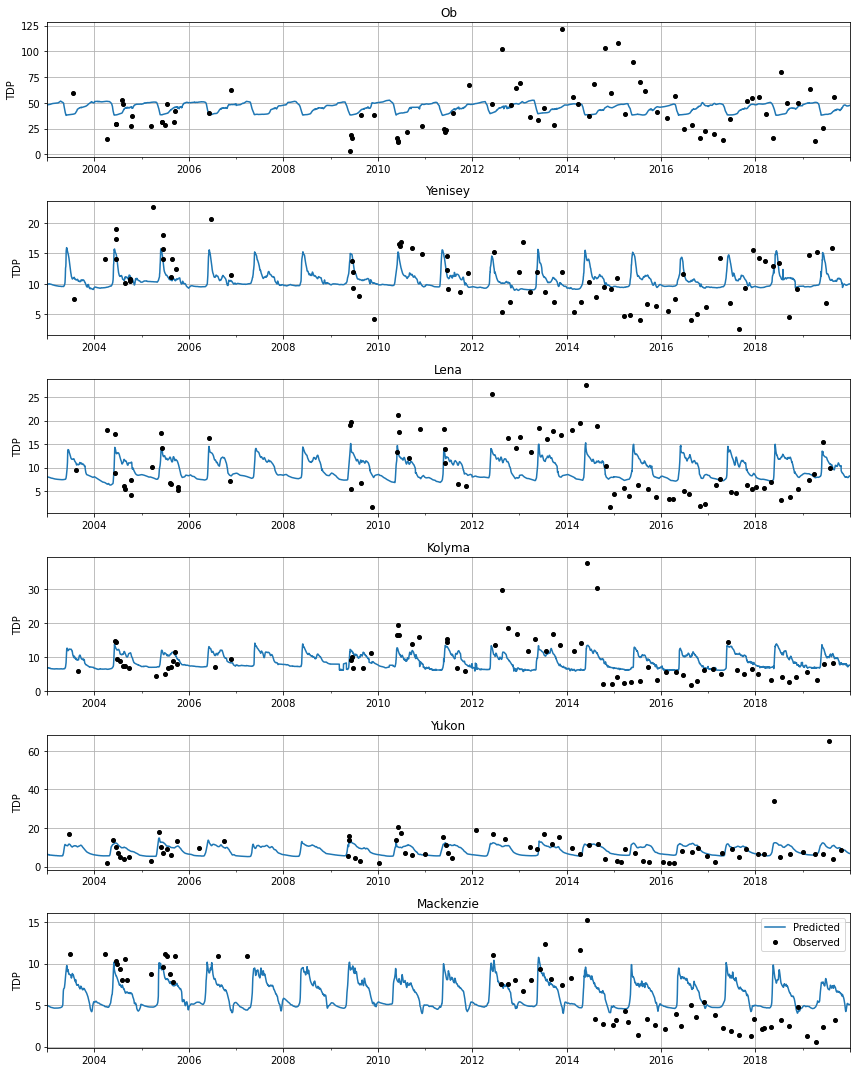

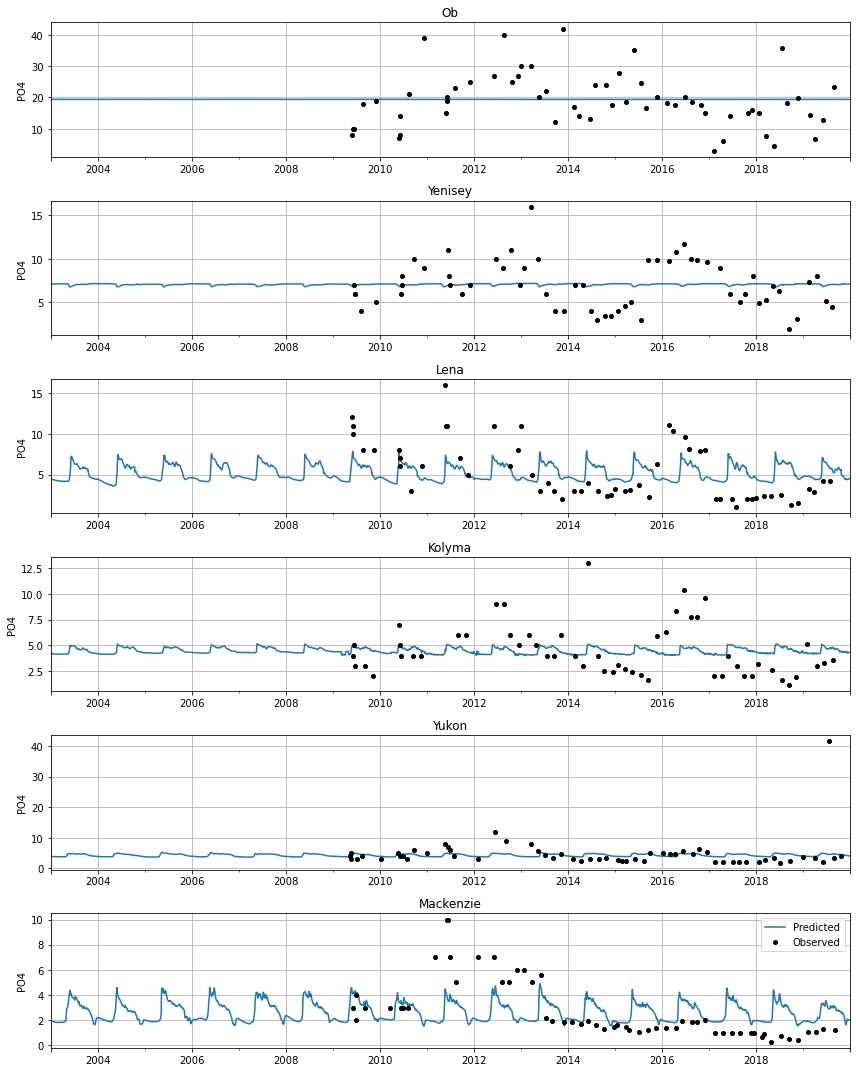

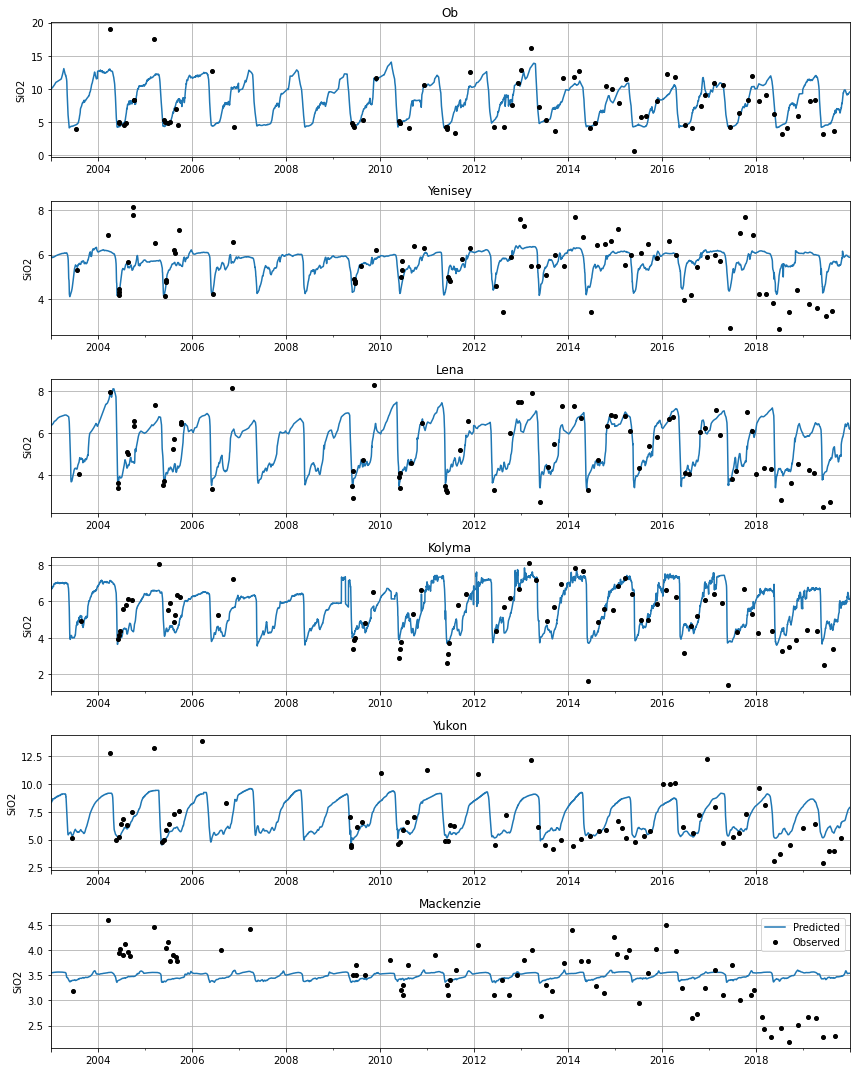

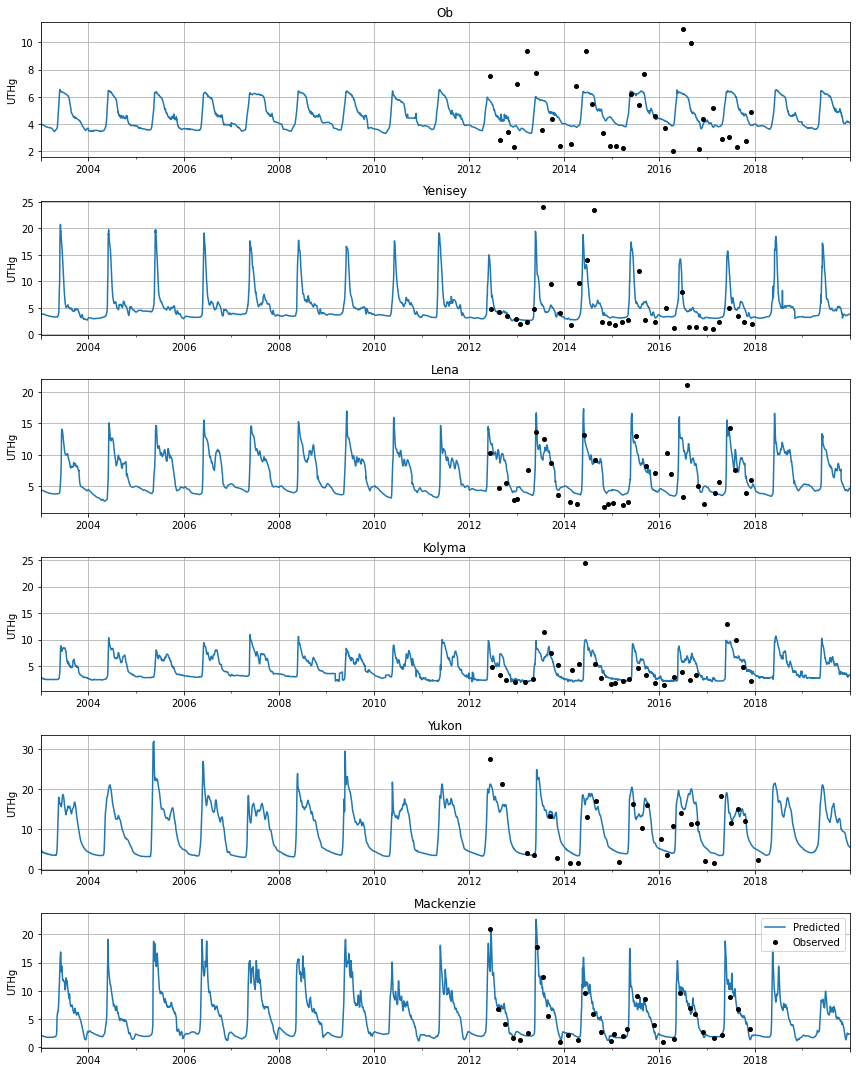

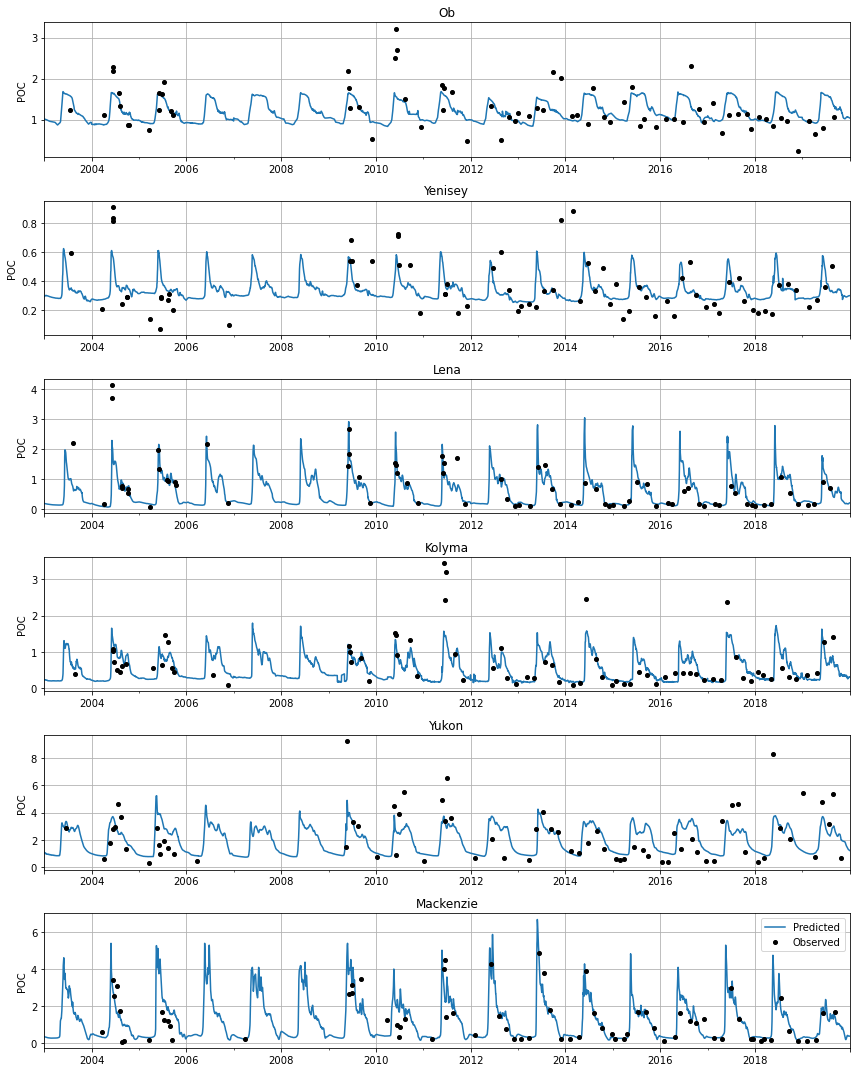

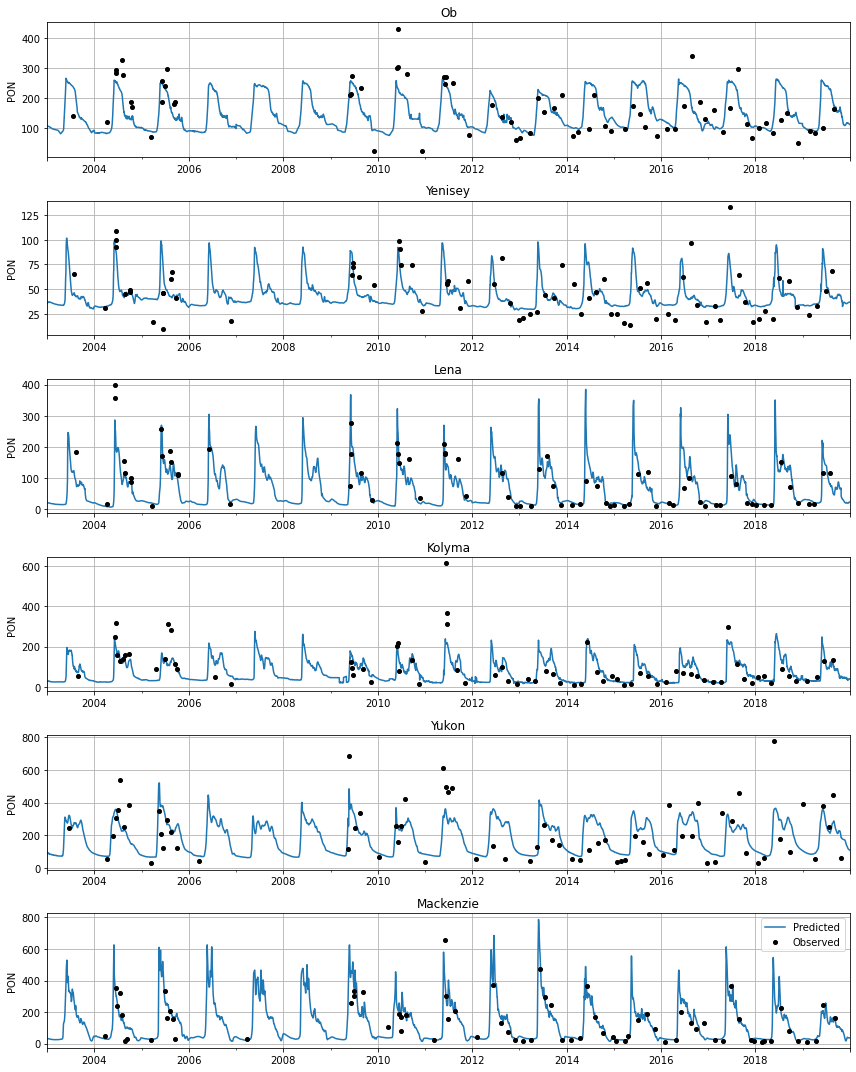

In [23]:
for chem in chem_vars_cq:
    df = predicted_chem_dict[chem]
    plot_predicted_obs_chem(df, chem, out_folder_predictions)

## Predict DON from DOC

In [24]:
doc_don_df.loc[river][0]

44.63372224366146

In [25]:
chem_vars_doc_c = ["DON"]

for var in chem_vars_doc_c:
    pred_li = []
    for river in rivers_li:
        pred = predicted_chem_dict['DOC'][river] / doc_don_df.loc[river][0]
        # Add to results
        pred.name = river
        pred_li.append(pred)

    # Make dataframe for this variable and save in dict and to file
    pred_df = pd.concat(pred_li, axis=1)
    predicted_chem_dict[var] = pred_df
    pred_fpath = os.path.join(out_folder_predictions, 'predictions',
                              'daily', '%s.csv' % var)
    pred_df.to_csv(pred_fpath)

predicted_chem_dict[var]

,Ob,Yenisey,Lena,Kolyma,Yukon,Mackenzie
date,,,,,,
1980-01-01,0.202275,0.102272,0.175057,0.068941,0.078623,0.082604
1980-01-02,0.202208,0.101917,0.175057,0.069159,0.078623,0.082956
1980-01-03,0.202208,0.101275,0.174746,0.069267,0.078623,0.083415
1980-01-04,0.202005,0.100988,0.174746,0.069375,0.078623,0.083696
1980-01-05,0.201802,0.100701,0.174746,0.069482,0.078623,0.083472
...,...,...,...,...,...,...
2019-12-27,0.199313,0.120955,0.172828,0.095423,0.091358,0.091841
2019-12-28,0.199101,0.120955,0.172828,0.096243,0.090890,0.091855
2019-12-29,0.198889,0.121559,0.173718,0.096343,0.090205,0.091866


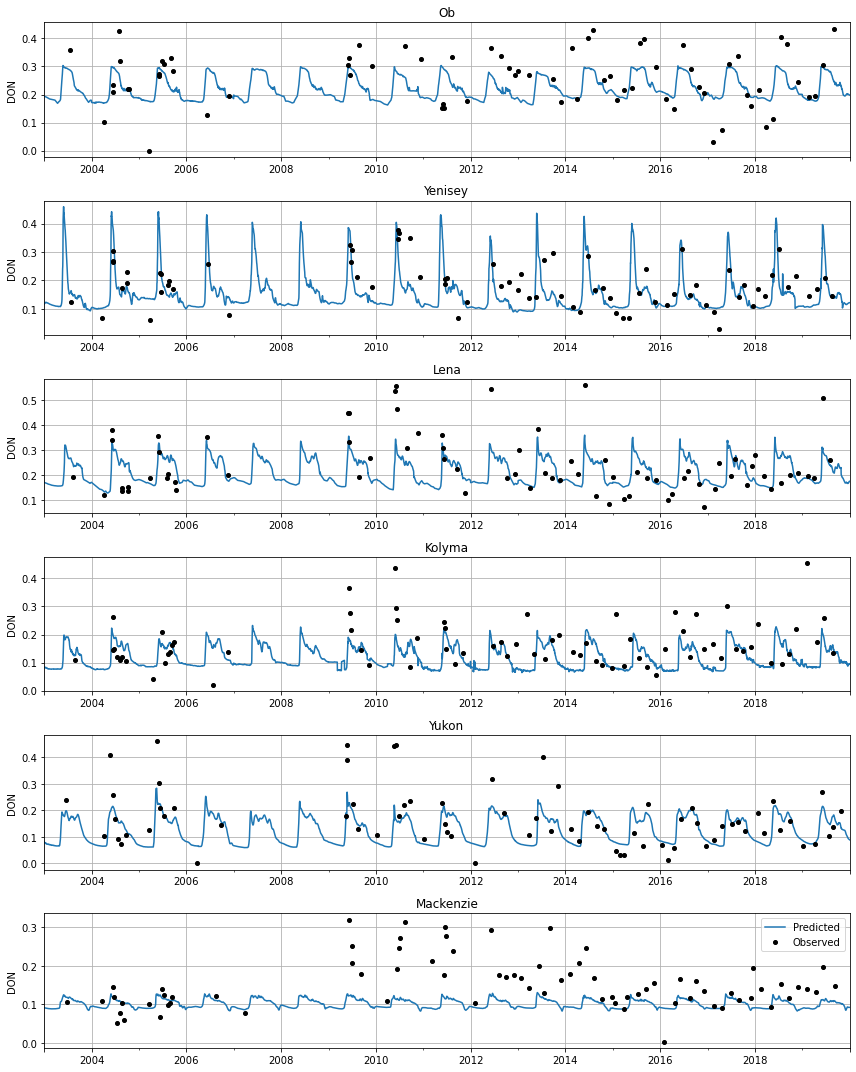

In [26]:
# Plot
for chem in chem_vars_doc_c:
    df = predicted_chem_dict[chem]
    plot_predicted_obs_chem(df, chem, out_folder_predictions)

## Constant concentrations

P fractions show very weak relationships or scattered relationships with flow and DOC:
* PO4 is essentially constant across Q
* TDP has quality issues (step change at lots of rivers) which looks dodgy, and (perhaps partly because of this) a very poor relation with Q (-ve in the polluted Ob', slight positive elsewhere)
* Calculated DHP (~DOP) shows ~no relationships with DOC or Q

Therefore just set all to the long-term mean.

In [27]:
chem_vars_constant = ["PO4", "DHP"]

for var in chem_vars_constant:
    pred_li = []
    for river in rivers_li:
        mean_chem = chem_dict[river][var].mean()
        pred = pd.Series(index=q_dict[river].index, data=mean_chem)
        # Add to results
        pred.name = river
        pred_li.append(pred)

    # Make dataframe for this variable and save in dict and to file
    pred_df = pd.concat(pred_li, axis=1)
    predicted_chem_dict[var] = pred_df
    pred_fpath = os.path.join(out_folder_predictions, 'predictions',
                              'daily', '%s.csv' % var)
    pred_df.to_csv(pred_fpath)

predicted_chem_dict[var]

,Ob,Yenisey,Lena,Kolyma,Yukon,Mackenzie
date,,,,,,
1980-01-01,25.562919,3.909423,5.775716,5.670497,5.176315,2.766425
1980-01-02,25.562919,3.909423,5.775716,5.670497,5.176315,2.766425
1980-01-03,25.562919,3.909423,5.775716,5.670497,5.176315,2.766425
1980-01-04,25.562919,3.909423,5.775716,5.670497,5.176315,2.766425
1980-01-05,25.562919,3.909423,5.775716,5.670497,5.176315,2.766425
...,...,...,...,...,...,...
2019-12-27,25.562919,3.909423,5.775716,5.670497,5.176315,2.766425
2019-12-28,25.562919,3.909423,5.775716,5.670497,5.176315,2.766425
2019-12-29,25.562919,3.909423,5.775716,5.670497,5.176315,2.766425


# Convert daily predicted chem to monthly mean

Could do a flow-weighted monthly mean. However, flow doesn't change THAT much within a month in these large rivers, and the predicted chemistry data is so uncertain anyway that it's probably not worth faffing with. Something to come back to in the future perhaps. If so, I found this code snippet for calculating weighted averages using dataframes which may be useful:

grouped = df.groupby('Date')

def wavg(group):
    d = group['value']
    w = group['wt']
    return (d * w).sum() / w.sum()

grouped.apply(wavg)

In [36]:
predicted_chem_monthly_dict = {}
for chem in predicted_chem_dict.keys():
    daily_df = predicted_chem_dict[chem]
    monthly_df = daily_df.resample('M').agg(np.mean)
    predicted_chem_monthly_dict[chem] = monthly_df

    # Write to csv
    fpath = os.path.join(out_folder_predictions, 'predictions', 'monthly_mean', '%s.csv' % chem)
    monthly_df.to_csv(fpath)

print(predicted_chem_monthly_dict['Alk']['Yenisey'].head(5))
# print(predicted_chem_dict['Alk']['Yenisey'].head(31))

date
1980-01-31    75.291093
1980-02-29    73.365272
1980-03-31    75.530779
1980-04-30    75.071790
1980-05-31    60.149119
Freq: M, Name: Yenisey, dtype: float64


<AxesSubplot:xlabel='date'>

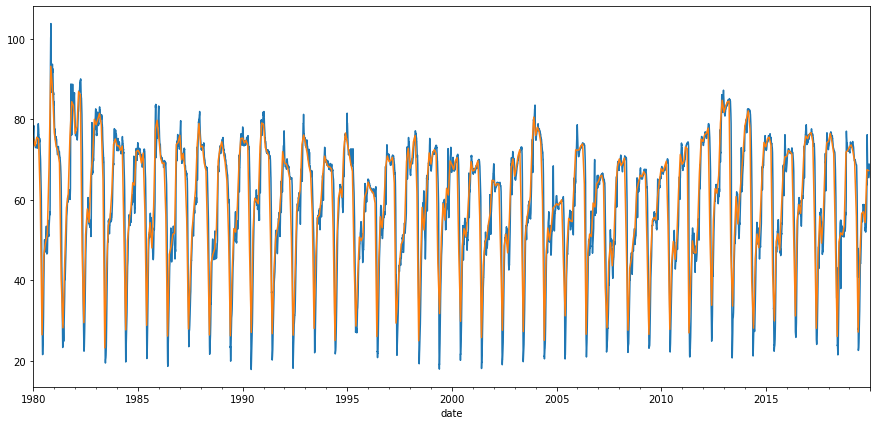

In [32]:
# Quick plot to check working ok
riv = 'Yenisey'
chem = 'Alk'
ax = plt.figure(figsize=(15,7)).add_subplot(111)
predicted_chem_dict[chem][riv].plot(ax=ax)
predicted_chem_monthly_dict[chem][riv].plot(ax=ax)

In [51]:
# # For the Yukon, have a big data gap where don't have Q. Fill using mean monthly mean from all other years
# chem = 'Alk'
# df = predicted_chem_monthly_dict[chem]

# # Work out mean monthly mean
# df['month'] = df.index.month
# monthly_mean_df = df.groupby(by=['month']).mean()
# # monthly_mean_df.plot()

In [ ]:
# # Add monthly means as new columns in continuous_df, then use to patch the
# # data gaps

#     df['%s_MMed' %var] = np.NaN
#     for i, date in enumerate(df.index):
#         monthly_mean = monthly_mean_df.loc[df.index.month, river]  # label-based selection
#         df.loc[i, river] = monthly_mean  # Set value

#     # Fill gaps with the values from the median column 
#     df[river].fillna(continuous_df['%s_MMed' %var], inplace=True)
    
#     df.loc[df[river] == np.NaN] = 